# Generate Input Data

In [27]:
import numpy as np
import pandas as pd
import random
#Generate 5 random numbers between 10 and 30
np.random.seed(0)
n_samples=1000
n_features = 5
df_XY=pd.DataFrame(data = np.random.normal(0,1, size=(n_samples, n_features)), columns = ['A','B','C','D','E'])
df_XY['Y']=list(np.random.randint(2, size=n_samples))
df_XY['YY']=list(np.random.randint(2, size=n_samples))
df_XY

##############################################################   
df_XY.shape
df_XY.head()
df_XY.to_csv('df_XY.csv',index=False)
##############################################################

In [28]:
df_XY

,A,B,C,D,E,Y,YY
0,1.764052,0.400157,0.978738,2.240893,1.867558,1,1
1,-0.977278,0.950088,-0.151357,-0.103219,0.410599,0,0
2,0.144044,1.454274,0.761038,0.121675,0.443863,0,0
3,0.333674,1.494079,-0.205158,0.313068,-0.854096,1,0
4,-2.552990,0.653619,0.864436,-0.742165,2.269755,0,1
...,...,...,...,...,...,...,...
995,1.711489,-1.820816,0.163495,-0.813117,-0.605355,0,0
996,-1.327524,-0.644172,1.908883,-0.563545,1.082473,1,0
997,-1.951911,2.441216,-0.017285,0.912282,1.239658,1,1
998,-0.573367,0.424889,-0.271260,-0.683568,-1.537438,1,1


# Download CI-VAE, other necessary packages and Load Packages

In [29]:
! rm -rf ci_vae
! rm bb.pt
! rm bb_residuals.pkl
! rm df_reconstructed.csv
! rm df_reconstructed_decoder.csv
! rm residuals.pdf
! rm results_dict.pkl
! rm df_latent.csv

rm: df_reconstructed.csv: No such file or directory
rm: df_reconstructed_decoder.csv: No such file or directory
rm: results_dict.pkl: No such file or directory
rm: df_latent.csv: No such file or directory


In [30]:
! git clone https://github.com/monabiyan/ci_vae.git
! pip install umap-learn

Cloning into 'ci_vae'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 334 (delta 48), reused 65 (delta 24), pack-reused 245
Receiving objects: 100% (334/334), 46.88 MiB | 5.06 MiB/s, done.
Resolving deltas: 100% (204/204), done.


In [31]:
import pandas as pd
import numpy as np
import sklearn
import torch
import pickle

In [ ]:
#import umap

In [32]:
import matplotlib.pyplot as plt
from ci_vae import ivae

# Set Necessary Parameters 

In [33]:
model_init=True
model_tobe_trained=True
save_address="bb"

kl_coef = 0.0001
reconst_coef = 1
classifier_coef = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Initialize the Model

In [34]:
obj1 = ivae.IVAE(df_XY = df_XY,
               latent_size = 2,
               reconst_coef = reconst_coef,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

if model_init:
    obj1.model_initialiaze()

## See The Model Architecture

In [35]:
print(obj1.model)

IVAE_ARCH(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (15): Dropout(p=0.05, inplace=False)
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): ReLU()
    (18): BatchNorm1d(20, eps=1e-05, momentum=0.2, affine=Tru

## See the Initialized Weights

In [36]:
for param in obj1.model.parameters():
    print(param)

Parameter containing:
tensor([[-0.2200, -0.0311, -0.3187,  0.0512,  0.0037],
        [-0.2980, -0.0701, -0.2644, -0.3377,  0.0365],
        [-0.1359,  0.0343, -0.2789,  0.3185,  0.2952],
        [ 0.4085,  0.0436,  0.2929,  0.2545, -0.0765],
        [-0.2045, -0.0104, -0.2330, -0.3084,  0.3366],
        [-0.3150,  0.1827, -0.2409, -0.3672, -0.3048],
        [-0.0883,  0.1794,  0.3068, -0.4053,  0.2801],
        [ 0.0562,  0.0938,  0.0022, -0.2357,  0.3789],
        [-0.0689,  0.1914,  0.4211, -0.1635,  0.0329],
        [-0.0394,  0.1990, -0.3799,  0.3463,  0.3213],
        [-0.0227, -0.3543, -0.3431,  0.0570,  0.4155],
        [-0.3112, -0.2825,  0.3977,  0.0452, -0.3098],
        [ 0.1274, -0.2553, -0.4094,  0.1679, -0.0977],
        [-0.0963, -0.3973, -0.1100, -0.1181,  0.0633],
        [-0.2314,  0.2761,  0.1616,  0.4420,  0.4101],
        [-0.2054,  0.3315,  0.3340,  0.3047, -0.1031],
        [ 0.1801, -0.3202, -0.0540, -0.3175,  0.4462],
        [ 0.0466,  0.0127,  0.1794,  0.0762

# RUN for Training

In [37]:
##########
if model_tobe_trained:
    lr=1e-2
    print(lr)
    obj1.model_training(epochs=100,learning_rate=lr)

    lr=1e-3
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    lr=1e-3
    print(lr)
    #obj.model_training(epochs=200,learning_rate=lr)

    obj1.model_save(address=save_address+".pt")
    obj1.save_residuals(address=save_address+'_residuals.pkl')
    lr=1e-3
    print(lr)
    #obj.model_training(epochs=70,learning_rate=lr)

    lr=5e-4
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)

    obj1.model_save(address=save_address+".pt")
    obj1.save_residuals(address=save_address+'_residuals.pkl')

    lr=1e-5
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)

    lr=5e-6
    print(lr)
    obj1.model_training(epochs=50,learning_rate=lr)


0.01
====> Epoch: 1 total_train_loss: 1.003043 Total_test_loss: 0.861384 Total_BCE_test_loss: 0.789584 Total_KLD_test_loss: 0.000008 Total_CEP_test_loss: 0.071792


/Users/mohsennabian/Desktop/ci_vae/example/ci_vae/ivae.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)
/Users/mohsennabian/Desktop/ci_vae/example/ci_vae/ivae.py:406: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(torch.reshape(y, (-1,)), dtype=torch.long)


====> Epoch: 2 total_train_loss: 0.945444 Total_test_loss: 0.858863 Total_BCE_test_loss: 0.788193 Total_KLD_test_loss: 0.000005 Total_CEP_test_loss: 0.070665
====> Epoch: 3 total_train_loss: 0.905730 Total_test_loss: 0.859141 Total_BCE_test_loss: 0.787589 Total_KLD_test_loss: 0.000003 Total_CEP_test_loss: 0.071548
====> Epoch: 4 total_train_loss: 0.891592 Total_test_loss: 0.859819 Total_BCE_test_loss: 0.787736 Total_KLD_test_loss: 0.000004 Total_CEP_test_loss: 0.072078
====> Epoch: 5 total_train_loss: 0.886691 Total_test_loss: 0.859672 Total_BCE_test_loss: 0.788107 Total_KLD_test_loss: 0.000011 Total_CEP_test_loss: 0.071554
====> Epoch: 6 total_train_loss: 0.879897 Total_test_loss: 0.857871 Total_BCE_test_loss: 0.785951 Total_KLD_test_loss: 0.000024 Total_CEP_test_loss: 0.071896
====> Epoch: 7 total_train_loss: 0.873857 Total_test_loss: 0.854008 Total_BCE_test_loss: 0.783077 Total_KLD_test_loss: 0.000046 Total_CEP_test_loss: 0.070884
====> Epoch: 8 total_train_loss: 0.879096 Total_test

====> Epoch: 54 total_train_loss: 0.703826 Total_test_loss: 0.667410 Total_BCE_test_loss: 0.596103 Total_KLD_test_loss: 0.001980 Total_CEP_test_loss: 0.069327
====> Epoch: 55 total_train_loss: 0.693999 Total_test_loss: 0.663751 Total_BCE_test_loss: 0.592477 Total_KLD_test_loss: 0.002014 Total_CEP_test_loss: 0.069260
====> Epoch: 56 total_train_loss: 0.696412 Total_test_loss: 0.660103 Total_BCE_test_loss: 0.588854 Total_KLD_test_loss: 0.002026 Total_CEP_test_loss: 0.069223
====> Epoch: 57 total_train_loss: 0.693126 Total_test_loss: 0.660357 Total_BCE_test_loss: 0.589098 Total_KLD_test_loss: 0.002045 Total_CEP_test_loss: 0.069214
====> Epoch: 58 total_train_loss: 0.696742 Total_test_loss: 0.658088 Total_BCE_test_loss: 0.586780 Total_KLD_test_loss: 0.002062 Total_CEP_test_loss: 0.069246
====> Epoch: 59 total_train_loss: 0.690401 Total_test_loss: 0.655209 Total_BCE_test_loss: 0.583859 Total_KLD_test_loss: 0.002095 Total_CEP_test_loss: 0.069255
====> Epoch: 60 total_train_loss: 0.684791 Tot

====> Epoch: 9 total_train_loss: 0.636581 Total_test_loss: 0.582941 Total_BCE_test_loss: 0.510864 Total_KLD_test_loss: 0.002762 Total_CEP_test_loss: 0.069314
====> Epoch: 10 total_train_loss: 0.638179 Total_test_loss: 0.581756 Total_BCE_test_loss: 0.509679 Total_KLD_test_loss: 0.002767 Total_CEP_test_loss: 0.069310
====> Epoch: 11 total_train_loss: 0.641211 Total_test_loss: 0.580853 Total_BCE_test_loss: 0.508796 Total_KLD_test_loss: 0.002752 Total_CEP_test_loss: 0.069305
====> Epoch: 12 total_train_loss: 0.641741 Total_test_loss: 0.580737 Total_BCE_test_loss: 0.508658 Total_KLD_test_loss: 0.002782 Total_CEP_test_loss: 0.069297
====> Epoch: 13 total_train_loss: 0.641891 Total_test_loss: 0.580403 Total_BCE_test_loss: 0.508345 Total_KLD_test_loss: 0.002767 Total_CEP_test_loss: 0.069292
====> Epoch: 14 total_train_loss: 0.636605 Total_test_loss: 0.580291 Total_BCE_test_loss: 0.508256 Total_KLD_test_loss: 0.002745 Total_CEP_test_loss: 0.069290
====> Epoch: 15 total_train_loss: 0.638174 Tota

====> Epoch: 13 total_train_loss: 0.635388 Total_test_loss: 0.573540 Total_BCE_test_loss: 0.501458 Total_KLD_test_loss: 0.002823 Total_CEP_test_loss: 0.069259
====> Epoch: 14 total_train_loss: 0.631552 Total_test_loss: 0.573593 Total_BCE_test_loss: 0.501539 Total_KLD_test_loss: 0.002790 Total_CEP_test_loss: 0.069264
====> Epoch: 15 total_train_loss: 0.630506 Total_test_loss: 0.573947 Total_BCE_test_loss: 0.501904 Total_KLD_test_loss: 0.002785 Total_CEP_test_loss: 0.069259
====> Epoch: 16 total_train_loss: 0.635097 Total_test_loss: 0.573337 Total_BCE_test_loss: 0.501285 Total_KLD_test_loss: 0.002788 Total_CEP_test_loss: 0.069264
====> Epoch: 17 total_train_loss: 0.633183 Total_test_loss: 0.573805 Total_BCE_test_loss: 0.501766 Total_KLD_test_loss: 0.002781 Total_CEP_test_loss: 0.069258
====> Epoch: 18 total_train_loss: 0.633649 Total_test_loss: 0.572803 Total_BCE_test_loss: 0.500744 Total_KLD_test_loss: 0.002797 Total_CEP_test_loss: 0.069262
====> Epoch: 19 total_train_loss: 0.632863 Tot

====> Epoch: 18 total_train_loss: 0.630953 Total_test_loss: 0.572334 Total_BCE_test_loss: 0.500271 Total_KLD_test_loss: 0.002803 Total_CEP_test_loss: 0.069261
====> Epoch: 19 total_train_loss: 0.638529 Total_test_loss: 0.572447 Total_BCE_test_loss: 0.500391 Total_KLD_test_loss: 0.002797 Total_CEP_test_loss: 0.069258
====> Epoch: 20 total_train_loss: 0.635099 Total_test_loss: 0.573262 Total_BCE_test_loss: 0.501228 Total_KLD_test_loss: 0.002772 Total_CEP_test_loss: 0.069262
====> Epoch: 21 total_train_loss: 0.636974 Total_test_loss: 0.573530 Total_BCE_test_loss: 0.501510 Total_KLD_test_loss: 0.002764 Total_CEP_test_loss: 0.069257
====> Epoch: 22 total_train_loss: 0.633180 Total_test_loss: 0.572549 Total_BCE_test_loss: 0.500502 Total_KLD_test_loss: 0.002788 Total_CEP_test_loss: 0.069260
====> Epoch: 23 total_train_loss: 0.631967 Total_test_loss: 0.573005 Total_BCE_test_loss: 0.500968 Total_KLD_test_loss: 0.002772 Total_CEP_test_loss: 0.069265
====> Epoch: 24 total_train_loss: 0.636707 Tot

# Save The Trained Model

In [38]:
##########
print("running the neural network")
#run(obj1,save_address)
obj1.model_save(address=save_address+".pt")
obj1.save_residuals(address=save_address+'_residuals.pkl')

running the neural network
model saved


# Visualize Residuals

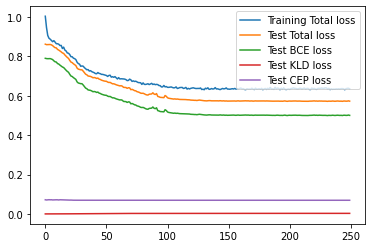

<Figure size 432x288 with 0 Axes>

In [39]:
obj1.plot_residuals(init_index=0)

# Load Model and Data

In [40]:
from ci_vae import ivae
import pandas as pd
import numpy as np
import sklearn
import torch
#import umap
import pickle
import matplotlib.pyplot as plt

In [41]:
print("start of the code")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##############################################################   
##############################################################
model_init=True
model_tobe_trained=False

model_init=True
model_file_address='./bb.pt'
save_address1="./"

df_XY=pd.read_csv('df_XY.csv')

start of the code


## Load Saved Model

In [42]:
obj2 = ivae.IVAE(df_XY = df_XY,
               reconst_coef = reconst_coef,
               latent_size = 10,
               kl_coef = kl_coef,
               classifier_coef = classifier_coef,
               test_ratio = 1)

#obj2.model_initialiaze()

obj2.model_load(address="bb.pt")

model loaded


()

## Print the Weights

In [43]:
for param in obj2.model.parameters():
    print(param)

AttributeError: 'dict' object has no attribute 'parameters'

# Make Prediction of All Test Data

In [44]:
with torch.no_grad():
    obj2.model.eval()

    obj2.load_residuals(address='bb_residuals.pkl')
    print("model loaded")
    
    obj2.generate_test_results()
    print("test data generated")

AttributeError: 'dict' object has no attribute 'eval'

# Comprehensive Checking of The Prediction Values vs. True Values. 

In [23]:
print(obj2.x_last)

AttributeError: 'IVAE' object has no attribute 'x_last'

In [ ]:
print(obj2.x_pred)

In [ ]:
(np.abs(obj2.x_pred - obj2.x_last)).mean()

In [ ]:
(obj2.x_pred-obj2.x_last)

In [ ]:
print(obj2.y_last)

In [ ]:
print(obj2.y_pred)

In [ ]:
df_XY

In [ ]:
with torch.no_grad():
    obj2.model.eval()
    for x, y in obj2.testloader:
      x = x.to(device)
      print(x.size())
      print(x)
      # forward
      x_hat,y_hat, mu, logvar,z = obj2.model(x)
    
    df_reconstructed = pd.DataFrame(x_hat.cpu().detach().numpy(), columns=obj2.df_XY.drop(columns=['Y']).columns)
    print(df_reconstructed.shape)
    df_latent=pd.DataFrame(z.cpu().detach().numpy())
    
    obj2.model.eval()
    
    df_reconstructed_decoder=pd.DataFrame(obj2.model.decoder(z).cpu().detach().numpy(), columns=obj2.df_XY.drop(columns=['Y']).columns)

    df_reconstructed.to_csv('df_reconstructed.csv')
    df_latent.to_csv('df_latent.csv')
    df_reconstructed_decoder.to_csv('df_reconstructed_decoder.csv')
    print("Full_data_reconstructed...")
    
    print("========df_reconstructed========")
    print(df_reconstructed)
    print("========df_reconstructed_decoder========")
    print(df_reconstructed_decoder)
    print("========df_Original========")
    print(df_XY)
    
    
    


# Checking Linear Separability of Data on Lower Dimensioanl Space

In [ ]:
print("regression analysis")
obj2.regression_analysis(obj2.zs,df_XY['Y'])

# Visualize Data on Lower Dimensional Space

In [ ]:
print("calculate tsne_umap_pca")
tsne_mat,umap_mat,pca_mat,Y=obj2.calculate_lower_dimensions(obj2.zs,obj2.y_last,N=100)
obj2.plot_lower_dimension(tsne_mat,Y,projection='3d',save_str='tsne3d.pdf')
obj2.plot_lower_dimension(tsne_mat,Y,projection='2d',save_str='tsne2d.pdf')
obj2.plot_lower_dimension(umap_mat,Y,projection='3d',save_str='umap3d.pdf')
obj2.plot_lower_dimension(umap_mat,Y,projection='2d',save_str='umap2d.pdf')
obj2.plot_lower_dimension(pca_mat,Y,projection='3d',save_str='pca3d.pdf')
obj2.plot_lower_dimension(pca_mat,Y,projection='2d',save_str='pca2d.pdf')

print("finished")


# Perform Interpolation across all groups (Y) and all features from YY=0 to YY=1

In [ ]:
ff = obj2.traversal_all_groups(traversal_step=5)

# See the interpolation results

In [ ]:
with open('results_dict.pkl', 'rb') as f:
    ff = pickle.load(f)

In [ ]:
ff['med']['0']

In [ ]:
ff['mean']['1']

In [ ]:
plt.plot(ff['med']['1']['B'])

In [ ]:
plt.plot(ff['mean']['1']['B'])

In [ ]:
plt.plot(ff['med']['0']['C'])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ff['mean']['0']['C'])

# Generate Synthetic Data for a Given Class

In [ ]:
bb = obj2.synthetic_single_group(group_id=0,nr_of_synthetic=1000)

In [ ]:
bb.shape

In [ ]:
bb